In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.1.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
matplotlib 3.1.0
numpy 1.16.4
pandas 0.24.2
sklearn 0.21.3
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
# read data from file
df = pd.read_csv("./data/AdvectionDiffusion/noise_00.csv")
x = df[['x', 'y', 'z', 't']].values
y = df['u'].values
u_t = df['u_t'].values
u_x = df['u_x'].values
u_y = df['u_y'].values
u_z = df['u_z'].values
u_xx = df['u_xx'].values
u_yy = df['u_yy'].values
u_zz = df['u_zz'].values

from sklearn.model_selection import train_test_split
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(2812, 4) (2812,)
(938, 4) (938,)
(1250, 4) (1250,)


In [3]:
def build_model(hidden_layers = 1, layer_size = 30, learning_rate = 3e-5):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation="sigmoid",
                                input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,
                                    activation = "sigmoid"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-10)]

In [4]:
# reconstruct the machine learning model
def s(input_x, input_y, input_z, input_t):
    i = 0
    for w, b in zip(kernel_tensor, bias_tensor):
        if i == 0:
            input_tensor = input_x*w[0,:] + input_y*w[1,:] + input_z*w[2,:] + input_t*w[3,:] + b
            input_tensor = tf.nn.sigmoid(input_tensor)
        elif i < len(kernel_tensor)-1:
            output_tensor = input_tensor@w + b
            output = tf.nn.sigmoid(output_tensor)
            input_tensor = output
        else:
            output_tensor = input_tensor@w + b
            output = output_tensor
        i += 1
    return output

In [6]:
input_array = x
input_x = tf.Variable(input_array[:, 0].reshape(5000, 1))
input_y = tf.Variable(input_array[:, 1].reshape(5000, 1))
input_z = tf.Variable(input_array[:, 2].reshape(5000, 1))
input_t = tf.Variable(input_array[:, 3].reshape(5000, 1))

In [16]:
layers = [i for i in range(1, 11)]
dx = []
dy = []
dz = []
dt = []
dxx = []
dyy = []
dzz = []
print("layers: ", layers)

layers:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [17]:
for hidden_layers in layers:
    model = build_model(hidden_layers = hidden_layers)
    history = model.fit(x_train, y_train, epochs = 100,
                        validation_data = (x_valid, y_valid),
                        callbacks = callbacks)
    from tensorflow import float64
    # get weights and bias in each layer
    i = 0
    kernel_tensor = []
    bias_tensor = []
    for each in model.weights:
        if i % 2 is 0:
            kernel_tensor.append(tf.constant(each.numpy(), dtype=float64))
        else:
            bias_tensor.append(tf.constant(each.numpy(), dtype=float64))
        i += 1
    # first derivatives
    with tf.GradientTape(persistent=True) as tape:
        output = s(input_x, input_y, input_z, input_t)
        
    ds_x = tape.gradient(output, input_x).numpy()
    ds_y = tape.gradient(output, input_y).numpy()
    ds_z = tape.gradient(output, input_z).numpy()
    ds_t = tape.gradient(output, input_t).numpy()

    del tape
    dx.append((ds_x.reshape(len(ds_x))-u_x).sum()/len(ds_x))
    dy.append((ds_y.reshape(len(ds_y))-u_y).sum()/len(ds_y))
    dz.append((ds_z.reshape(len(ds_z))-u_z).sum()/len(ds_z))
    dt.append((ds_t.reshape(len(ds_t))-u_t).sum()/len(ds_t))
    # second derivatives
    with tf.GradientTape(persistent=True) as outer_tape:
        with tf.GradientTape(persistent=True) as inner_tape:
            output = s(input_x, input_y, input_z, input_t)
        inner_grads = inner_tape.gradient(output, [input_x, input_y, input_z])
    # outer_grads = [outer_tape.gradient(inner_grad, [input_x, input_y, input_z]) for inner_grad in inner_grads]
    ds_xx = outer_tape.gradient(inner_grads[0], [input_x])[0].numpy()
    ds_yy = outer_tape.gradient(inner_grads[1], [input_y])[0].numpy()
    ds_zz = outer_tape.gradient(inner_grads[2], [input_z])[0].numpy()

    del inner_tape
    del outer_tape
    dxx.append((ds_xx.reshape(len(ds_xx))-u_xx).sum()/len(ds_xx))
    dyy.append((ds_yy.reshape(len(ds_yy))-u_yy).sum()/len(ds_yy))
    dzz.append((ds_zz.reshape(len(ds_zz))-u_zz).sum()/len(ds_zz))

Train on 2812 samples, validate on 938 samples
Epoch 1/100
2812/2812 [==============================] - 0s 87us/sample - loss: 0.0876 - val_loss: 0.0753
Epoch 2/100
2812/2812 [==============================] - 0s 28us/sample - loss: 0.0849 - val_loss: 0.0730
Epoch 3/100
2812/2812 [==============================] - 0s 28us/sample - loss: 0.0825 - val_loss: 0.0708
Epoch 4/100
2812/2812 [==============================] - 0s 28us/sample - loss: 0.0803 - val_loss: 0.0689
Epoch 5/100
2812/2812 [==============================] - 0s 28us/sample - loss: 0.0782 - val_loss: 0.0671
Epoch 6/100
2812/2812 [==============================] - 0s 28us/sample - loss: 0.0764 - val_loss: 0.0655
Epoch 7/100
2812/2812 [==============================] - 0s 27us/sample - loss: 0.0747 - val_loss: 0.0641
Epoch 8/100
2812/2812 [==============================] - 0s 29us/sample - loss: 0.0732 - val_loss: 0.0627
Epoch 9/100
2812/2812 [==============================] - 0s 28us/sample - loss: 0.0717 - val_loss: 0.0615

Epoch 8/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.3713 - val_loss: 0.3319
Epoch 9/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.3391 - val_loss: 0.3021
Epoch 10/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.3101 - val_loss: 0.2755
Epoch 11/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.2842 - val_loss: 0.2517
Epoch 12/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.2610 - val_loss: 0.2304
Epoch 13/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.2402 - val_loss: 0.2113
Epoch 14/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.2216 - val_loss: 0.1943
Epoch 15/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.2049 - val_loss: 0.1790
Epoch 16/100
2812/2812 [==============================] - 0s 29us/sample - loss: 0.1899 - val_loss: 0.1653
Epoch 17/100
2812/2812 [===============

2812/2812 [==============================] - 0s 30us/sample - loss: 0.1041 - val_loss: 0.0887
Epoch 3/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0995 - val_loss: 0.0846
Epoch 4/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0953 - val_loss: 0.0809
Epoch 5/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.0916 - val_loss: 0.0776
Epoch 6/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.0882 - val_loss: 0.0746
Epoch 7/100
2812/2812 [==============================] - 0s 29us/sample - loss: 0.0851 - val_loss: 0.0719
Epoch 8/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.0824 - val_loss: 0.0695
Epoch 9/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.0799 - val_loss: 0.0674
Epoch 10/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.0777 - val_loss: 0.0654
Epoch 11/100
2812/2812 [==============================] -

2812/2812 [==============================] - 0s 32us/sample - loss: 0.0574 - val_loss: 0.0502
Epoch 18/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0574 - val_loss: 0.0501
Epoch 19/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0573 - val_loss: 0.0501
Epoch 20/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0573 - val_loss: 0.0500
Epoch 21/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0573 - val_loss: 0.0500
Epoch 22/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0573 - val_loss: 0.0499
Epoch 23/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0572 - val_loss: 0.0499
Epoch 24/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0572 - val_loss: 0.0498
Epoch 25/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0572 - val_loss: 0.0498
Epoch 26/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 33us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 94/100
2812/2812 [==============================] - 0s 40us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 95/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 96/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 97/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 98/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 99/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 100/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0493
Train on 2812 samples, validate on 938 samples
Epoch 1/100
2812/2812 [==============================] - 0s 120us/sample - loss: 0.1305 - val_loss: 0.1122
Ep

Epoch 8/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.2189 - val_loss: 0.1925
Epoch 9/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.2019 - val_loss: 0.1770
Epoch 10/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.1867 - val_loss: 0.1632
Epoch 11/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1732 - val_loss: 0.1508
Epoch 12/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1610 - val_loss: 0.1398
Epoch 13/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1501 - val_loss: 0.1299
Epoch 14/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1404 - val_loss: 0.1211
Epoch 15/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1316 - val_loss: 0.1132
Epoch 16/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1238 - val_loss: 0.1062
Epoch 17/100
2812/2812 [===============

2812/2812 [==============================] - 0s 34us/sample - loss: 0.6594 - val_loss: 0.5972
Epoch 10/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.5916 - val_loss: 0.5345
Epoch 11/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.5314 - val_loss: 0.4790
Epoch 12/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.4781 - val_loss: 0.4298
Epoch 13/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.4308 - val_loss: 0.3862
Epoch 14/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.3888 - val_loss: 0.3475
Epoch 15/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.3515 - val_loss: 0.3132
Epoch 16/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.3184 - val_loss: 0.2829
Epoch 17/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.2891 - val_loss: 0.2560
Epoch 18/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 35us/sample - loss: 0.0911 - val_loss: 0.0770
Epoch 3/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0874 - val_loss: 0.0737
Epoch 4/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0841 - val_loss: 0.0708
Epoch 5/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0811 - val_loss: 0.0683
Epoch 6/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0785 - val_loss: 0.0660
Epoch 7/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0762 - val_loss: 0.0640
Epoch 8/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0741 - val_loss: 0.0622
Epoch 9/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0722 - val_loss: 0.0607
Epoch 10/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0706 - val_loss: 0.0593
Epoch 11/100
2812/2812 [==============================] -

2812/2812 [==============================] - 0s 36us/sample - loss: 0.0607 - val_loss: 0.0543
Epoch 26/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0603 - val_loss: 0.0539
Epoch 27/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0600 - val_loss: 0.0535
Epoch 28/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0597 - val_loss: 0.0531
Epoch 29/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0594 - val_loss: 0.0528
Epoch 30/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0592 - val_loss: 0.0525
Epoch 31/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0590 - val_loss: 0.0522
Epoch 32/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0588 - val_loss: 0.0520
Epoch 33/100
2812/2812 [==============================] - 0s 38us/sample - loss: 0.0586 - val_loss: 0.0518
Epoch 34/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 151us/sample - loss: 0.2964 - val_loss: 0.2877
Epoch 2/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.2718 - val_loss: 0.2639
Epoch 3/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.2498 - val_loss: 0.2425
Epoch 4/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.2301 - val_loss: 0.2232
Epoch 5/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.2124 - val_loss: 0.2059
Epoch 6/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.1965 - val_loss: 0.1904
Epoch 7/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.1822 - val_loss: 0.1764
Epoch 8/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.1694 - val_loss: 0.1638
Epoch 9/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.1579 - val_loss: 0.1525
Epoch 10/100
2812/2812 [==============================] -

Epoch 78/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0571 - val_loss: 0.0496
Epoch 79/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0571 - val_loss: 0.0496
Epoch 80/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0571 - val_loss: 0.0495
Epoch 81/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0571 - val_loss: 0.0495
Epoch 82/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0571 - val_loss: 0.0495
Epoch 83/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0571 - val_loss: 0.0495
Epoch 84/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0571 - val_loss: 0.0495
Epoch 85/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0570 - val_loss: 0.0495
Epoch 86/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0570 - val_loss: 0.0495
Epoch 87/100
2812/2812 [=============

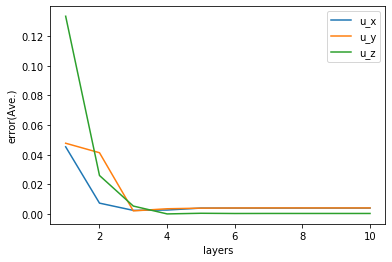

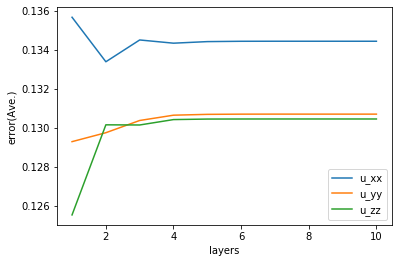

In [24]:
# plot the figure 
plt.plot(layers, list(map(abs, dx)), label='u_x')
plt.plot(layers, list(map(abs, dy)), label='u_y')
plt.plot(layers, list(map(abs, dz)), label='u_z')
# plt.plot(layers, list(map(abs, dt)), label='u_t')
plt.legend()
plt.xlabel('layers')
plt.ylabel('error(Ave.)')
plt.show()
plt.plot(layers, dxx, label='u_xx')
plt.plot(layers, dyy, label='u_yy')
plt.plot(layers, dzz, label='u_zz')
plt.legend()
plt.xlabel('layers')
plt.ylabel('error(Ave.)')
plt.show()

In [ ]:
def length_ratio(x, y, z, u0):
    du0 = np.array([3, 4, 5])
    ratio = ((x ** 2 + y ** 2 + z ** 2) ** 0.5 / 
             (du0[0] ** 2 + du0[1] ** 2 + du0[2] ** 2) ** 0.5)
    return ratio

print('Length ratio : {}'.format(length_ratio(ds_x, ds_y, ds_z, input_array)))

In [ ]:
import math
def theta(x, y, z, u0):
    du0 = np.array([3, 4, 5])
    mol_du0 = (du0[0] ** 2 + du0[1] ** 2 + du0[2] ** 2) ** 0.5
    mol_xyz = (x ** 2 + y ** 2 + z ** 2) ** 0.5
    acos = math.acos(
        np.dot(du0, u0[0]) / (mol_du0 * mol_xyz))
    return acos

print('Theta : {} rad'.format(theta(ds_x, ds_y, ds_z, input_array)))